In [5]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------------------------------------ --- 1.3/1.4 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.7 MB/s eta 0:00:00


In [6]:
import pandas as pd

# Load dataset
train_data = pd.read_csv('E:\\Studies\\IIT\\4 - Forth Year\\Applied AI\\Course Work\\Dataset  - Main - Allstate Claims Severity\\train.csv')  # Replace with your file path
test_data = pd.read_csv('E:\\Studies\\IIT\\4 - Forth Year\\Applied AI\\Course Work\\Dataset  - Main - Allstate Claims Severity\\test.csv')    # Replace with your file path

# Display dataset information
print("Train Data Info:")
print(train_data.info())
print("Test Data Info:")
print(test_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB
None
Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB
None


In [7]:
# Ensure 'loss' is numeric
train_data['loss'] = pd.to_numeric(train_data['loss'], errors='coerce')

# Separate numeric columns
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])

# Calculate correlation with the target variable
correlation_matrix = numeric_data.corr()
correlation_with_target = correlation_matrix['loss'].abs()

# Automatically select features with high correlation
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
selected_features.remove('loss')  # Exclude the target column

# Add categorical features
categorical_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
selected_features += categorical_columns

print("Selected Features:", selected_features)

Selected Features: ['cont2', 'cont3', 'cont7', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', '

In [8]:
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder

# Separate features and target
X_train = train_data[selected_features]
y_train = train_data['loss']

# Identify categorical and numeric columns
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
numeric_columns = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64']]

# Encode categorical variables
encoder = OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])

# Scale numeric features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns)

# Combine processed features
X_train_processed = pd.concat([X_train_scaled, X_train_encoded.reset_index(drop=True)], axis=1)

print("Preprocessed Training Data Shape:", X_train_processed.shape)

c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(


Preprocessed Training Data Shape: (188318, 1142)


In [9]:
import lightgbm as lgb

# Convert data to LightGBM dataset format
dtrain = lgb.Dataset(X_train_processed, label=y_train)

# Define LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 10,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the LightGBM model
lgb_model = lgb.train(lgb_params, dtrain, num_boost_round=1000)
print("LightGBM Model Trained Successfully!")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 188318, number of used features: 836
[LightGBM] [Info] Start training from score 3037.337685
LightGBM Model Trained Successfully!


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the training data
y_train_pred_lgb = lgb_model.predict(X_train_processed)

# Calculate metrics
mse_lgb = mean_squared_error(y_train, y_train_pred_lgb)
rmse_lgb = mse_lgb ** 0.5  # Root Mean Squared Error
mae_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
r2_lgb = r2_score(y_train, y_train_pred_lgb)

print(f"LightGBM RMSE: {rmse_lgb}")
print(f"LightGBM MAE: {mae_lgb}")
print(f"LightGBM R² Score: {r2_lgb}")


LightGBM RMSE: 1828.3960679354507
LightGBM MAE: 1177.2652010736551
LightGBM R² Score: 0.6036089305962855


In [11]:
# Create a DataFrame for comparison
comparison_df_lgb = pd.DataFrame({
    'ID': train_data['id'],  # Assuming 'id' exists in the dataset
    'Actual Loss': y_train,
    'Predicted Loss (LGBM)': y_train_pred_lgb
})

# Save to CSV
comparison_csv_path_lgb = 'lgbm_loss_comparison.csv'
comparison_df_lgb.to_csv(comparison_csv_path_lgb, index=False)
print(f"Comparison results saved to: {comparison_csv_path_lgb}")

Comparison results saved to: lgbm_loss_comparison.csv


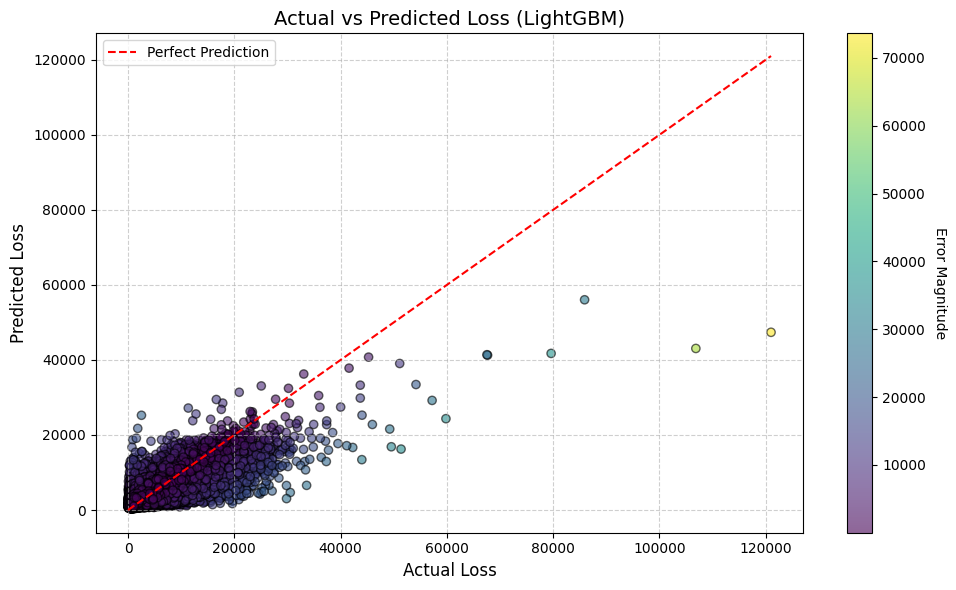

In [12]:
import matplotlib.pyplot as plt

# Scatterplot of Actual vs Predicted Loss
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    y_train, 
    y_train_pred_lgb, 
    alpha=0.6, 
    c=abs(y_train - y_train_pred_lgb), 
    cmap='viridis', 
    edgecolor='k'
)

# Add a colorbar to show the error magnitude
cbar = plt.colorbar(scatter)
cbar.set_label('Error Magnitude', rotation=270, labelpad=15)

# Add labels, title, and grid
plt.xlabel("Actual Loss", fontsize=12)
plt.ylabel("Predicted Loss", fontsize=12)
plt.title("Actual vs Predicted Loss (LightGBM)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Add diagonal reference line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()